In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optim
from scipy.integrate import odeint, solve_ivp

In [25]:
def set_parameters(which):
    N = 50
    k = 0
    if (which == 'authors'):
        m_p0p1 = 0.0265
        m_p4950 = 0.0057

        m_p0G = 0.0022
        m_p49G = 0.0031

        m_p0S = 0.0027
        m_p49S = 0.0052

        m_p0A = 0.0018
        m_p49A = 0.0016

        m_GS = 6.837 * 10**(-4)
        m_AD = 0.0011
        
    elif (which == 'ours_uniform'):
        m_p0p1 = 0.0222
        m_p4950 = 0.0088

        m_p0G = 7.85*10**(-4)
        m_p49G = 2.19*10**(-7)

        m_p0S = 0.0014
        m_p49S = 0.0035

        m_p0A = 0.0027
        m_p49A = 0.0083

        m_GS = 0.05
        m_AD = 0.0263

        k = 3.71 * 10**(-4)
    elif (which == 'ours_exp'):
        m_p0p1 = 0.0347
        m_p4950 = 0.0051

        m_p0G = 0.0132
        m_p49G = 0.0021

        m_p0S = 0.0023
        m_p49S = 0.0014

        m_p0A = 0.0015
        m_p49A = 0.0013

        m_GS = 1.0781*10**(-4)
        m_AD = 0.0026

        k = 0.0502
    elif (which == 'ours_linear'):
        m_p0p1 = 0.0347
        m_p4950 = 0.0051

        m_p0G = 0.0132
        m_p49G = 0.0021

        m_p0S = 0.0023
        m_p49S = 0.0014

        m_p0A = 0.0015
        m_p49A = 0.0013

        m_GS = 1.0781*10**(-4)
        m_AD = 0.0026

        k = 0.0502
    return m_p0p1, m_p4950, m_p0G, m_p49G, m_p0S, m_p49S, m_p0A, m_p49A, m_GS, m_AD, k, N

In [4]:
def set_probability_dist(dist, i=None):
    if dist == 'uniform':
        return [1/50] * 50
    elif dist == 'exp':
        return [2**x/((2**50 - 1)) for x in range(0, 50)]
    elif dist == 'linear':
        return interpolate(0, 1/25)
    elif dist == 'singleton':
        prob = [0] * 50
        prob[i] = 1
        return prob

In [5]:
def interpolate(left, right, plot=False):
    x = np.arange(1, N-1)
    xp = [0, N-1]
    fp = [left, right]
    y = np.interp(x, xp, fp)
    y = list(y)
    y.append(right)
    y.insert(0, left)
    if plot:
        plt.plot(np.arange(1,N+1), y)
        plt.show()
    return y

In [6]:
def f_original(t, v, m_pipinext, m_piG, m_piS, m_piA, m_GS, m_AD):
    all_prolifs = []
    S = v[50]
    G = v[51]
    A = v[52]
    for i in range(N):
        all_prolifs.append(v[i])

    prolif_1_to_49_f = []
    f0 = -(m_pipinext[0] + m_piS[0] + m_piA[0] + m_piG[0]) * all_prolifs[0]
    for i in range(1, N):
        prolif_1_to_49_f.append(2 * m_pipinext[i] * all_prolifs[i-1] -
                                (m_pipinext[i] + m_piS[i] + m_piA[i] + m_piG[i]) * all_prolifs[i])

    fS = 2 * m_pipinext[-1] * all_prolifs[-1] + m_GS * G
    for i in range(N):
        fS += m_piS[i] * all_prolifs[i]

    fG = -m_GS * G
    for i in range(N):
        fG += m_piG[i] * all_prolifs[i]

    fA = -m_AD * A
    for i in range(N):
        fA += m_piA[i] * all_prolifs[i]

    return [f0, *prolif_1_to_49_f, fS, fG, fA]

In [7]:
def f(t, v, m_pipinext, m_piG, m_piS, m_piA, m_GS, m_AD, k, prob):
    all_prolifs = []
    S = v[50]
    G = v[51]
    A = v[52]
    for i in range(N):
        all_prolifs.append(v[i])

    prolif_1_to_49_f = []
    f0 = -(m_pipinext[0] + m_piS[0] + m_piA[0] + m_piG[0]) * all_prolifs[0] + prob[0] * k * G
    for i in range(1, N):
        prolif_1_to_49_f.append(2 * m_pipinext[i] * all_prolifs[i-1] -
                                (m_pipinext[i] + m_piS[i] + m_piA[i] + m_piG[i]) * all_prolifs[i] + prob[i] * k * G)

    fS = 2 * m_pipinext[-1] * all_prolifs[-1] + m_GS * G
    for i in range(N):
        fS += m_piS[i] * all_prolifs[i]

    fG = -m_GS * G - k * G
    for i in range(N):
        fG += m_piG[i] * all_prolifs[i]

    fA = -m_AD * A
    for i in range(N):
        fA += m_piA[i] * all_prolifs[i]

    return [f0, *prolif_1_to_49_f, fS, fG, fA]

In [22]:
m_p0p1, m_p4950, m_p0G, m_p49G, m_p0S, m_p49S, m_p0A, m_p49A, m_GS, m_AD, k, N = set_parameters('authors')

In [23]:
m_pipinext = interpolate(m_p0p1, m_p4950)
m_piG = interpolate(m_p0G, m_p49G)
m_piS = interpolate(m_p0S, m_p49S)
m_piA = interpolate(m_p0A, m_p49A)

In [101]:
# prob = set_probability_dist('singleton', 10)

In [150]:
prob = set_probability_dist('linear')

In [178]:
sum([i * 2/49 * 1/49 for i in range(0, 50)])

1.0204081632653061

In [151]:
sum(prob)

1.0

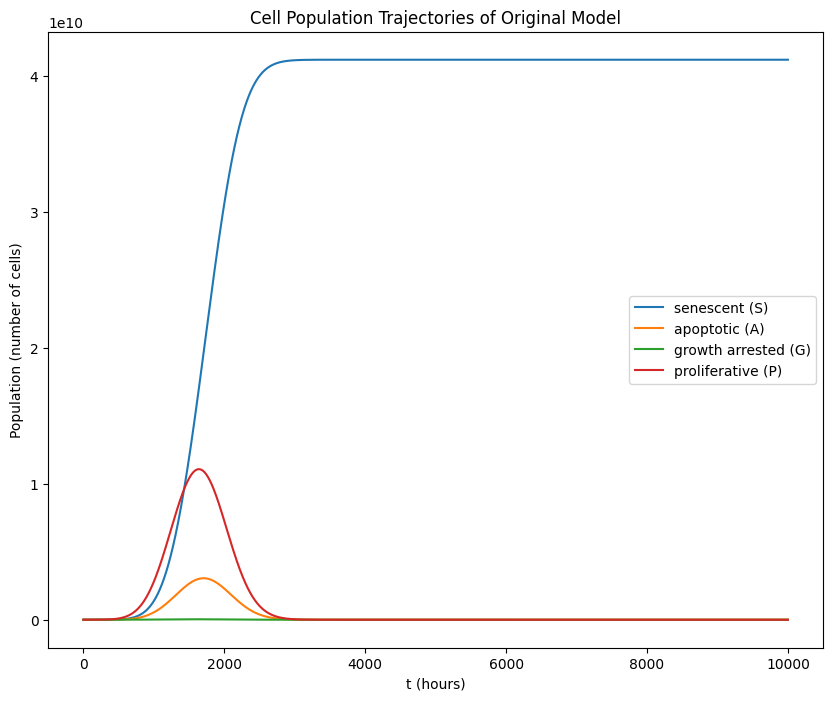

In [10]:
ic = [150000]
ic = ic + [0] * (N + 2)

t  = np.linspace(0, 10000, 10000) 
soln = odeint(f_original, ic, t, tfirst=True, args=(m_pipinext, m_piG, m_piS, m_piA, m_GS, m_AD,))

all_prolifs = []

for i in range(N):
    all_prolifs.append(soln[:, i])

S = soln[:, N]
G = soln[:, N + 1]
A = soln[:, N + 2]
P = np.sum(np.array(all_prolifs), axis=0)
TP = S + G + A + P
plt.figure(figsize=(10, 8))
plt.plot(t, S, label='senescent (S)')
plt.plot(t, A, label='apoptotic (A)')
plt.plot(t, G, label='growth arrested (G)')
plt.plot(t, P, label='proliferative (P)')
# plt.plot(t, all_prolifs[4], label='P49')
# plt.plot(t, TP, label='Total population (TP)')

# plt.plot(t, v, label='v')
plt.xlabel('t (hours)')
plt.ylabel('Population (number of cells)')
plt.legend()
plt.title('Cell Population Trajectories of Original Model')
plt.savefig("orig_model_trajectories.png")
plt.show()
# plt.savefig(f'3c_{alpha}', bbox_inches='tight')

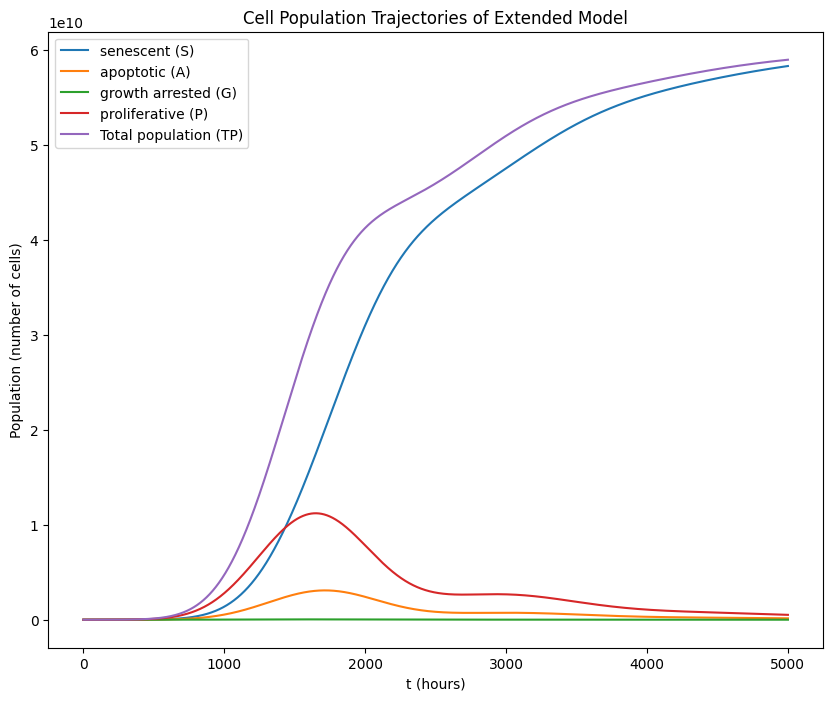

In [152]:
ic = [150000]
ic = ic + [0] * (N + 2)

t  = np.linspace(0, 5000, 10000) 
soln = odeint(f, ic, t, tfirst=True, args=(m_pipinext, m_piG, m_piS, m_piA, m_GS, m_AD, k, prob))

all_prolifs = []

for i in range(N):
    all_prolifs.append(soln[:, i])

S = soln[:, N]
G = soln[:, N + 1]
A = soln[:, N + 2]
P = np.sum(np.array(all_prolifs), axis=0)
TP = S + G + A + P
plt.figure(figsize=(10, 8))
plt.plot(t, S, label='senescent (S)')
plt.plot(t, A, label='apoptotic (A)')
plt.plot(t, G, label='growth arrested (G)')
plt.plot(t, P, label='proliferative (P)')
# plt.plot(t, all_prolifs[49], label='P2')
plt.plot(t, TP, label='Total population (TP)')

# plt.plot(t, v, label='v')
plt.xlabel('t (hours)')
plt.ylabel('Population (number of cells)')
plt.legend()
plt.title('Cell Population Trajectories of Extended Model')
# plt.savefig("new_model_trajectories_singleton_10.png")
plt.show()

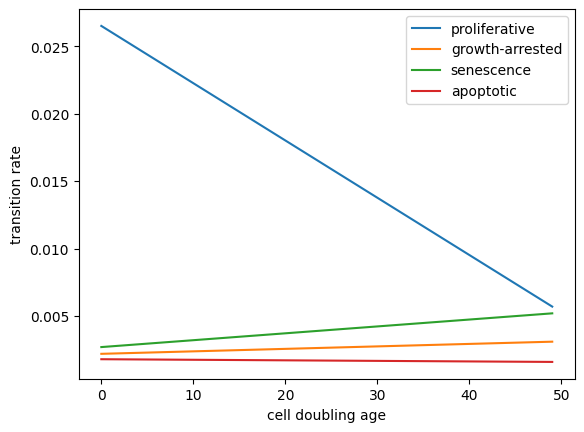

In [26]:
plt.plot(m_pipinext, label = 'proliferative')
plt.plot(m_piG, label = 'growth-arrested')
plt.plot(m_piS, label = 'senescence')
plt.plot(m_piA, label = 'apoptotic')
plt.xlabel('cell doubling age')
plt.ylabel('transition rate')
plt.legend()
plt.savefig("transition_rates_authors.png")
plt.show()